# Examples of each Unit of the Congestion Finder

This _Jupyter Notebook_ documents all the classes, objects and functions of the _congestion finder_ module. It shows how each work by giving a short example.

## Initialisation

The _Jupyter Notebook_ is initialised by loading all required modules and turning on logging.

### Imports

The following modules are required for this _Jupyter Notebook_. The _congestion finder_ module lives in the parent directory of this _documentation_ directory, so we need to append that directory to the _system path_ to be able to load the module.

In [23]:
import numpy
import matplotlib.pyplot
import logging
import io
import re
import ast
import sys
sys.path.append("../")
import congestionfinder
import congestionfinder.bpsdetector
import congestionfinder.road
import congestionfinder.detection
import congestionfinder.speedflow
import congestionfinder.congestion
import patchfinder.patch

### Logging

To see what is going on while the functions are called, logging is turned on. It is set to _debug_ level.

In [24]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(formatter)
logger.addHandler(consoleHandler)

When running the _patch finder_ functions, it is also useful to extract specific logging information to build plots. Therefore, a second logger is introduced with a filter for these patches. This logger writes directly into a string variable.

In [25]:
class PlotFilter(logging.Filter):
    def filter(self, record):
        return "Found patches:" in record.getMessage()

log_capture_string = io.StringIO()
variableHandler = logging.StreamHandler(log_capture_string)
variableHandler.addFilter(PlotFilter())
logger.addHandler(variableHandler)

## Classes

The following classes contain objects and functions.

### BPS Detectors

A _BPS detector_ can be identified using a 20-digit hexadecimal number, the _BPS code_. This number encodes all relevant information. The _constructor_ of the _BPSDetector object_ takes this number as a string and parses it to the relevant variables.

In [26]:
bpsDetector = congestionfinder.bpsdetector.BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208 | additionalMeters: 91


### Roads

A _road_ can be identified by its number. Therefore, the _constructor_ of the _Road object_ takes as input a number.

In [27]:
road = congestionfinder.road.Road(12)
print(road)

roadNumber: 12 | len(bpsDetectors): 0 | len(spaceToSpaceIndex): 0


Each _Road object_ contains a set of _BPSDetector objects_. Therefore, the _road class_ contains a function to add a _BPSDetector object_.

In [28]:
road.addBPSDetector(bpsDetector)
print(road)

roadNumber: 12 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 0


The _BPS detectors_ can be ordered in space, along the _road_. Once all _BPSDetector objects_ have been added to the _Road object_, this set can be ordered into an index. The _road class_ contains a function to do this.

In [29]:
road.indexDetectorSpaces()
print(road)
print(road.getSpaceToSpaceIndex())

roadNumber: 12 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 1
{20891: 0}


As _roads_ are essentially a specific lists of _BPS detectors_, the _road class_ contains a function which can parse a set of _BPSDetector object_ directly to a set of _Road objects_.

In [30]:
bpsDetectors = []
bpsDetectors.append(congestionfinder.bpsdetector.BPSDetector("10D00204C00038200005"))
bpsDetectors.append(congestionfinder.bpsdetector.BPSDetector("10D00204D037D007000B"))
bpsDetectors.append(congestionfinder.bpsdetector.BPSDetector("10D002051800D0070013"))
bpsDetectors.append(congestionfinder.bpsdetector.BPSDetector("10D002057000D007000F"))
bpsDetectors.append(congestionfinder.bpsdetector.BPSDetector("10D01005381ED0070007"))
roads = congestionfinder.road.parseBPSDetectorsToRoads(bpsDetectors)
for value in roads.values():
    value.indexDetectorSpaces()

2018-01-03 14:49:12,515 - DEBUG - Starting parseBPSDetectorsToRoads()
2018-01-03 14:49:12,515 - DEBUG - Starting parseBPSDetectorsToRoads()
2018-01-03 14:49:12,530 - DEBUG - Ending parseBPSDetectorsToRoads()
2018-01-03 14:49:12,530 - DEBUG - Ending parseBPSDetectorsToRoads()


The following prints the resulting set of _Road objects_, which in this example consists of 1 _Road object_ with 4 _BPSDetector objects_ and 1 _Road object_ with 1 _BPSDetector object_. 

In [31]:
for road in roads.values():
    print(road)

roadNumber: 2 | len(bpsDetectors): 4 | len(spaceToSpaceIndex): 4
roadNumber: 16 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 1


### Detections

A _detection_ consists of a measurement of average _speed_ and average _flow_ at a specific location and time. The _constructor_ of the _Detection object_ takes as input a _BPS code_, a _space_ and _time_ location and the _speed_ and _flow_ data.

In [32]:
detection = congestionfinder.detection.Detection("00D00C03405B18200005", 1234, 1440, 120, 17)
print(detection)

code: 00D00C03405B18200005 | space: 1234 | time: 1440 | speed: 120 | flow: 17


### Speed and Flows (part 1)

A set of _detections_ along a single _road_ can be represented as two arrays of _speeds_ and _flows_. The _speedflow class_ contains a function which parses a set of _Detection objects_ into such arrays. It uses information about the structure of the _Road object_ to map the _Detection objects_ to the right location. It also gives the boundaries in _space_ and in _time_ of these arrays. As the input _road_, one of the _Road objects_ constructed above is used.

In [33]:
detections = []
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 1, 100, 1))
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 2, 85, 20))
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 3, 80, 17))
detections.append(congestionfinder.detection.Detection("10D00204C00038200005", 30400, 4, 70, 15))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 1, 100, 1))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 2, 55, 18))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 3, 35, 12))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 4, 40, 14))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 1, 95, 1))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 2, 85, 14))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 3, 100, 19))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 4, 90, 16))
road = roads[2]
speeds, flows, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex = congestionfinder.speedflow.parseDetectionsToSpeedsAndFlows(detections, road)

2018-01-03 14:49:12,593 - DEBUG - Starting parseDetectionsToSpeedFlows()
2018-01-03 14:49:12,593 - DEBUG - Starting parseDetectionsToSpeedFlows()
2018-01-03 14:49:12,608 - DEBUG - Ending parseDetectionsToSpeedFlows()
2018-01-03 14:49:12,608 - DEBUG - Ending parseDetectionsToSpeedFlows()


These _speeds_ and _flows_ arrays are both 4 by 4 matrices. A plot shows the matrices.

(4, 4)
(4, 4)
0
3
1
4


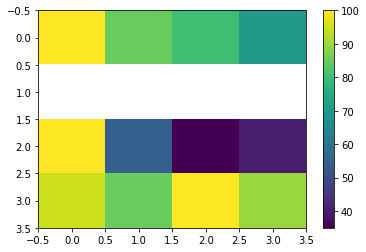

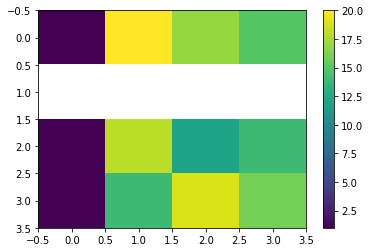

In [34]:
print(speeds.shape)
print(flows.shape)
print(minSpaceIndex)
print(maxSpaceIndex)
print(minTimeIndex)
print(maxTimeIndex)
matplotlib.pyplot.imshow(speeds, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flows, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In real life, it may occur that a _BPS detector_ is out of order. In this case, no information from that location is known. As such, the _speed_ and _flow_ data may contain gaps and its boundaries may not be the same as the start and finish of the _road_. Therefore, the _speedflow class_ contains a function which can remove such locations. It returns trimmed arrays for _speed_ and _flow_ data, and a _mask_ which can be used to identify the space index with the original spatial location of the _Detection object_.

In [35]:
speedsWorkingDetectors, flowsWorkingDetectors, maskWorkingDetectors = congestionfinder.speedflow.removeMissingDetectors(speeds, flows)

2018-01-03 14:49:12,999 - DEBUG - Starting removeMissingDetectors()
2018-01-03 14:49:12,999 - DEBUG - Starting removeMissingDetectors()
2018-01-03 14:49:12,999 - DEBUG - Ending removeMissingDetectors()
2018-01-03 14:49:12,999 - DEBUG - Ending removeMissingDetectors()


In this example, there is a missing detector at space index 1 which can be removed. The resulting arrays are both 4 by 3 matrices. A plot shows the matrices.

(3, 4)
(3, 4)
0.75


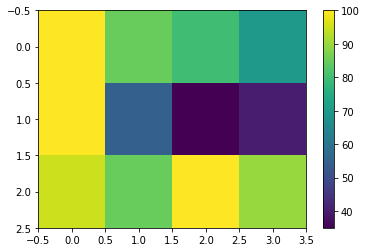

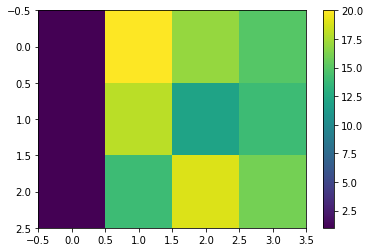

In [36]:
print(speedsWorkingDetectors.shape)
print(flowsWorkingDetectors.shape)
print(sum(maskWorkingDetectors) / (sum(maskWorkingDetectors) + sum(~maskWorkingDetectors)))
matplotlib.pyplot.imshow(speedsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

Not all _detection_ data is reliable or relevant. When the _flow_ is low, the measurements of average _speed_ are less accurate. Furthermore, there is no possibility for congestion. Low _flow_ occurs consistently at specific times, such as during the night. The _speedflow class_ contains a function which can remove such low _flow_ times. It returns trimmed arrays for _speed_ and _flow_ data, and a _mask_ which can be used to identify the time index with the original temporal location of the _Detection object_.

In [37]:
speedsHighFlow, flowsHighFlow, maskHighFlow = congestionfinder.speedflow.removeLowFlowTimes(speedsWorkingDetectors, flowsWorkingDetectors)

2018-01-03 14:49:13,327 - DEBUG - Starting removeLowFlowTimes()
2018-01-03 14:49:13,327 - DEBUG - Starting removeLowFlowTimes()
2018-01-03 14:49:13,327 - DEBUG - Ending removeLowFlowTimes()
2018-01-03 14:49:13,327 - DEBUG - Ending removeLowFlowTimes()


In this example, there is low _flow_ at time index 0. The resulting arrays are both 3 by 3 matrices. A plot shows the matrices.

(3, 3)
(3, 3)
0.75


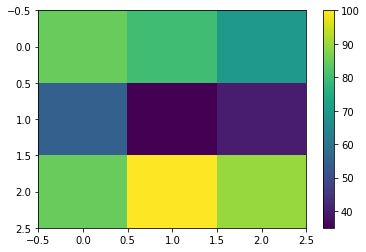

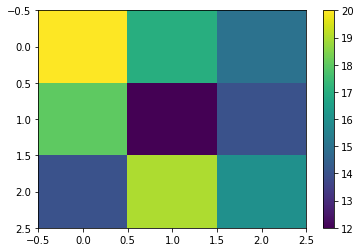

In [38]:
print(speedsHighFlow.shape)
print(flowsHighFlow.shape)
print(sum(maskHighFlow) / (sum(maskHighFlow) + sum(~maskHighFlow)))
matplotlib.pyplot.imshow(speedsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

### Congestion

_Speed_ and _flow_ data can be combined to devise a measure of _congestion_. The _Congestion class_ contains a function which takes the _speed_ and _flow_ arrays and, based on two thresholds, returns an array where any value below 1 indicates _congestion_. As the input arrays, the _speeds_ and _flows_ constructed above are used.

In [39]:
speedThreshold = 65
flowThreshold = 40
congestions = congestionfinder.congestion.parseSpeedFlowsToCongestions(speedsHighFlow, flowsHighFlow, speedThreshold, flowThreshold)

2018-01-03 14:49:13,640 - DEBUG - Starting parseSpeedFlowsToCongestions()
2018-01-03 14:49:13,640 - DEBUG - Starting parseSpeedFlowsToCongestions()
2018-01-03 14:49:13,640 - DEBUG - Ending parseSpeedFlowsToCongestions()
2018-01-03 14:49:13,640 - DEBUG - Ending parseSpeedFlowsToCongestions()


In this example, the resulting array is a 3 by 3 matrix. A plot shows the matrix.

(3, 3)


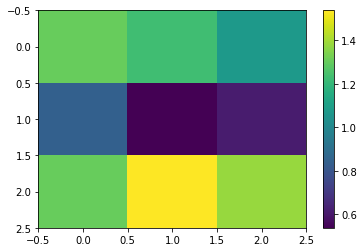

In [40]:
print(congestions.shape)
matplotlib.pyplot.imshow(congestions, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In real life, this array may contain missing values. This can occur when a _BPS detector_ is temporarily out of order. The _congestion class_ contains a function which can impute the missing values.

In [41]:
congestions[1, 1] = numpy.nan
congestionsWithoutMissingValues = congestionfinder.congestion.interpolateMissingValues(congestions)

2018-01-03 14:49:13,812 - DEBUG - Starting interpolateMissingValues()
2018-01-03 14:49:13,812 - DEBUG - Starting interpolateMissingValues()
2018-01-03 14:49:13,827 - DEBUG - Ending interpolateMissingValues()
2018-01-03 14:49:13,827 - DEBUG - Ending interpolateMissingValues()


The resulting array is, again, a 3 by 3 matrix. A plot shows the matrix.

(3, 3)


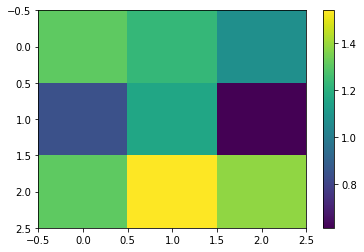

In [42]:
print(congestionsWithoutMissingValues.shape)
matplotlib.pyplot.imshow(congestionsWithoutMissingValues, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

The original _speed_ and _flow_ data were at a fine-grained level. _Congestion_ naturally occurs at a coarser level. Furthermore, while searching for _congestion_, is it important not to get thrown off by a single outlying value in the _speed_ or _flow_ data. Therefore, it is useful to smooth the _congestion_ array to a coarse-grained level. The _congestion class_ contains a smoothing function which takes the _congestion_ array and two parameters indicating the level of smoothing in the spatial and in the temporal dimension.

In [43]:
spaceSmoothing = 2
timeSmoothing = 3
congestionsSmoothed = congestionfinder.congestion.applySmoothingFilter(congestionsWithoutMissingValues, spaceSmoothing, timeSmoothing)

2018-01-03 14:49:14,046 - DEBUG - Starting applySmoothingFilter()
2018-01-03 14:49:14,046 - DEBUG - Starting applySmoothingFilter()
2018-01-03 14:49:14,046 - DEBUG - Ending applySmoothingFilter()
2018-01-03 14:49:14,046 - DEBUG - Ending applySmoothingFilter()


The resulting array is, again, a 3 by 3 matrix. The values, however, are averaged out more. A plot shows the matrix.

(3, 3)


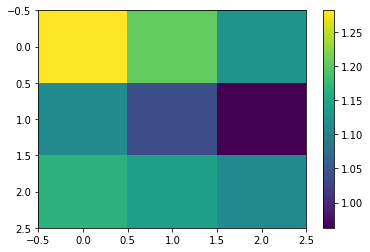

In [44]:
print(congestionsSmoothed.shape)
matplotlib.pyplot.imshow(congestionsSmoothed, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Patch Finder

The _patch finder_ module is an integral part of the _congestion finder_ module, but is more general. It is a module with a function which can find patches of _True_ in a boolean array. As such, any type of array can be entered, with some condition which turns it boolean. The function will return a set of _Patch objects_. The _Patch object_ includes the start and the end index in both dimensions. In principle, the concept of the _patch finder_ module can be extended to more dimensions, but that is not necessary here.

In [45]:
testDataArray = numpy.random.rand(16,9)
testBooleanArray = testDataArray >= 0.9
print(testBooleanArray)

[[False False False  True False False False False False]
 [False  True False False False False False False False]
 [False False False False False False False False  True]
 [False False  True False False  True False False False]
 [False False False  True False False  True False False]
 [False False False False False False False False False]
 [False False False False False  True False  True False]
 [False False False False False False False False False]
 [False False False False False  True False False False]
 [ True False False False  True False False  True False]
 [False False False False False  True False False False]
 [False False False False False False False False  True]
 [False  True False False False False False False False]
 [False False False False False False False False False]
 [ True False False False False False False False False]
 [False False False False False  True False False False]]


The _patch class_ contains a function which takes the example boolean array constructed above. It recursively searches for smaller patches within each patch and finally returns a list of _Patch objects_.

In [46]:
patches = patchfinder.patch.findPatches(testBooleanArray)

2018-01-03 14:49:14,234 - DEBUG - Starting findPatches()
2018-01-03 14:49:14,234 - DEBUG - Starting findPatches()
2018-01-03 14:49:14,234 - DEBUG - Direction: 0
2018-01-03 14:49:14,234 - DEBUG - Direction: 0
2018-01-03 14:49:14,249 - DEBUG - Starting scanForBoundaries()
2018-01-03 14:49:14,249 - DEBUG - Starting scanForBoundaries()
2018-01-03 14:49:14,249 - DEBUG - Found start: 0
2018-01-03 14:49:14,249 - DEBUG - Found start: 0
2018-01-03 14:49:14,249 - DEBUG - Found stop at end.
2018-01-03 14:49:14,249 - DEBUG - Found stop at end.
2018-01-03 14:49:14,249 - DEBUG - Ending scanForBoundaries()
2018-01-03 14:49:14,249 - DEBUG - Ending scanForBoundaries()
2018-01-03 14:49:14,265 - DEBUG - Found patches: [[0, 15, 0, 8]]
2018-01-03 14:49:14,265 - DEBUG - Found patches: [[0, 15, 0, 8]]
2018-01-03 14:49:14,265 - DEBUG - length: 1| parentLength: 0
2018-01-03 14:49:14,265 - DEBUG - length: 1| parentLength: 0
2018-01-03 14:49:14,265 - DEBUG - Scanning children...
2018-01-03 14:49:14,265 - DEBUG -

2018-01-03 14:49:14,374 - DEBUG -           Ending scanForBoundaries()
2018-01-03 14:49:14,374 - DEBUG -           Ending scanForBoundaries()
2018-01-03 14:49:14,374 - DEBUG -           Found patches: [[1, 1, 1, 1]]
2018-01-03 14:49:14,374 - DEBUG -           Found patches: [[1, 1, 1, 1]]
2018-01-03 14:49:14,374 - DEBUG -           length: 1| parentLength: 2
2018-01-03 14:49:14,374 - DEBUG -           length: 1| parentLength: 2
2018-01-03 14:49:14,374 - DEBUG -           Scanning children...
2018-01-03 14:49:14,374 - DEBUG -           Scanning children...
2018-01-03 14:49:14,374 - DEBUG -           Child: 0
2018-01-03 14:49:14,374 - DEBUG -           Child: 0
2018-01-03 14:49:14,374 - DEBUG -             Starting findPatches()
2018-01-03 14:49:14,374 - DEBUG -             Starting findPatches()
2018-01-03 14:49:14,390 - DEBUG -             Direction: 0
2018-01-03 14:49:14,390 - DEBUG -             Direction: 0
2018-01-03 14:49:14,390 - DEBUG -             Starting scanForBoundaries()
2

2018-01-03 14:49:14,515 - DEBUG -       Direction: 1
2018-01-03 14:49:14,515 - DEBUG -       Direction: 1
2018-01-03 14:49:14,515 - DEBUG -       Starting scanForBoundaries()
2018-01-03 14:49:14,515 - DEBUG -       Starting scanForBoundaries()
2018-01-03 14:49:14,515 - DEBUG -       Found start: 3
2018-01-03 14:49:14,515 - DEBUG -       Found start: 3
2018-01-03 14:49:14,515 - DEBUG -       Found stop at end.
2018-01-03 14:49:14,515 - DEBUG -       Found stop at end.
2018-01-03 14:49:14,515 - DEBUG -       Ending scanForBoundaries()
2018-01-03 14:49:14,515 - DEBUG -       Ending scanForBoundaries()
2018-01-03 14:49:14,515 - DEBUG -       Found patches: [[3, 4, 5, 6]]
2018-01-03 14:49:14,515 - DEBUG -       Found patches: [[3, 4, 5, 6]]
2018-01-03 14:49:14,515 - DEBUG -       length: 1| parentLength: 3
2018-01-03 14:49:14,515 - DEBUG -       length: 1| parentLength: 3
2018-01-03 14:49:14,515 - DEBUG -       Scanning children...
2018-01-03 14:49:14,515 - DEBUG -       Scanning children..

2018-01-03 14:49:14,640 - DEBUG -         Starting scanForBoundaries()
2018-01-03 14:49:14,640 - DEBUG -         Length is one
2018-01-03 14:49:14,640 - DEBUG -         Length is one
2018-01-03 14:49:14,655 - DEBUG -         Ending scanForBoundaries()
2018-01-03 14:49:14,655 - DEBUG -         Ending scanForBoundaries()
2018-01-03 14:49:14,655 - DEBUG -         Found patches: [[6, 6, 5, 5]]
2018-01-03 14:49:14,655 - DEBUG -         Found patches: [[6, 6, 5, 5]]
2018-01-03 14:49:14,655 - DEBUG -         length: 1| parentLength: 1
2018-01-03 14:49:14,655 - DEBUG -         length: 1| parentLength: 1
2018-01-03 14:49:14,655 - DEBUG -         Done: xStart: 6 | xEnd: 6 | yStart: 5 | yEnd: 5
2018-01-03 14:49:14,655 - DEBUG -         Done: xStart: 6 | xEnd: 6 | yStart: 5 | yEnd: 5
2018-01-03 14:49:14,655 - DEBUG -         Ending findPatches()
2018-01-03 14:49:14,655 - DEBUG -         Ending findPatches()
2018-01-03 14:49:14,655 - DEBUG -       Ending findPatches()
2018-01-03 14:49:14,655 - DEBU

2018-01-03 14:49:14,812 - DEBUG -           Starting findPatches()
2018-01-03 14:49:14,827 - DEBUG -           Direction: 1
2018-01-03 14:49:14,827 - DEBUG -           Direction: 1
2018-01-03 14:49:14,827 - DEBUG -           Starting scanForBoundaries()
2018-01-03 14:49:14,827 - DEBUG -           Starting scanForBoundaries()
2018-01-03 14:49:14,827 - DEBUG -           Length is one
2018-01-03 14:49:14,827 - DEBUG -           Length is one
2018-01-03 14:49:14,827 - DEBUG -           Ending scanForBoundaries()
2018-01-03 14:49:14,827 - DEBUG -           Ending scanForBoundaries()
2018-01-03 14:49:14,827 - DEBUG -           Found patches: [[9, 9, 0, 0]]
2018-01-03 14:49:14,827 - DEBUG -           Found patches: [[9, 9, 0, 0]]
2018-01-03 14:49:14,827 - DEBUG -           length: 1| parentLength: 1
2018-01-03 14:49:14,827 - DEBUG -           length: 1| parentLength: 1
2018-01-03 14:49:14,827 - DEBUG -           Done: xStart: 9 | xEnd: 9 | yStart: 0 | yEnd: 0
2018-01-03 14:49:14,827 - DEBUG -

2018-01-03 14:49:15,015 - DEBUG -       length: 2| parentLength: 3
2018-01-03 14:49:15,015 - DEBUG -       Scanning children...
2018-01-03 14:49:15,015 - DEBUG -       Scanning children...
2018-01-03 14:49:15,015 - DEBUG -       Child: 0
2018-01-03 14:49:15,015 - DEBUG -       Child: 0
2018-01-03 14:49:15,030 - DEBUG -         Starting findPatches()
2018-01-03 14:49:15,030 - DEBUG -         Starting findPatches()
2018-01-03 14:49:15,030 - DEBUG -         Direction: 0
2018-01-03 14:49:15,030 - DEBUG -         Direction: 0
2018-01-03 14:49:15,030 - DEBUG -         Starting scanForBoundaries()
2018-01-03 14:49:15,030 - DEBUG -         Starting scanForBoundaries()
2018-01-03 14:49:15,030 - DEBUG -         Found start: 0
2018-01-03 14:49:15,030 - DEBUG -         Found start: 0
2018-01-03 14:49:15,030 - DEBUG -         Found stop: 0
2018-01-03 14:49:15,030 - DEBUG -         Found stop: 0
2018-01-03 14:49:15,030 - DEBUG -         Ending scanForBoundaries()
2018-01-03 14:49:15,030 - DEBUG -   

2018-01-03 14:49:15,140 - DEBUG -       Found patches: [[14, 14, 0, 0]]
2018-01-03 14:49:15,155 - DEBUG -       length: 1| parentLength: 2
2018-01-03 14:49:15,155 - DEBUG -       length: 1| parentLength: 2
2018-01-03 14:49:15,155 - DEBUG -       Scanning children...
2018-01-03 14:49:15,155 - DEBUG -       Scanning children...
2018-01-03 14:49:15,155 - DEBUG -       Child: 0
2018-01-03 14:49:15,155 - DEBUG -       Child: 0
2018-01-03 14:49:15,155 - DEBUG -         Starting findPatches()
2018-01-03 14:49:15,155 - DEBUG -         Starting findPatches()
2018-01-03 14:49:15,155 - DEBUG -         Direction: 0
2018-01-03 14:49:15,155 - DEBUG -         Direction: 0
2018-01-03 14:49:15,155 - DEBUG -         Starting scanForBoundaries()
2018-01-03 14:49:15,155 - DEBUG -         Starting scanForBoundaries()
2018-01-03 14:49:15,155 - DEBUG -         Length is one
2018-01-03 14:49:15,155 - DEBUG -         Length is one
2018-01-03 14:49:15,155 - DEBUG -         Ending scanForBoundaries()
2018-01-03 

To visualise what the algorithm does, the second logger can be used. This writes all messages to a variable, which can be parsed using a regular expression. For each step of the recursive process, the information is plotted together with the original boolean array.

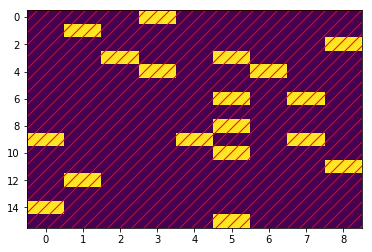

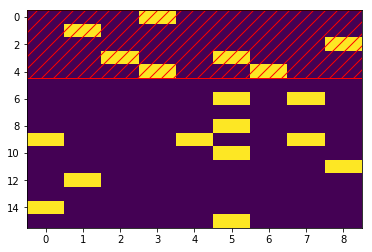

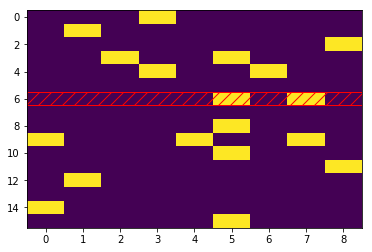

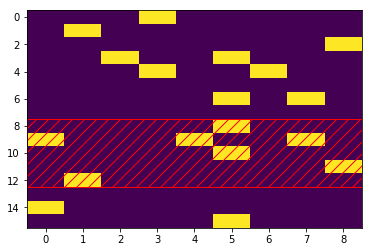

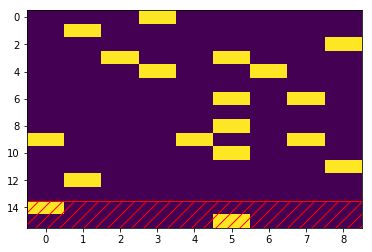

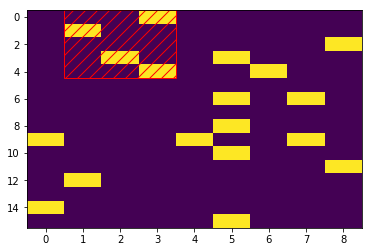

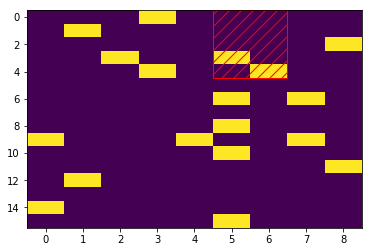

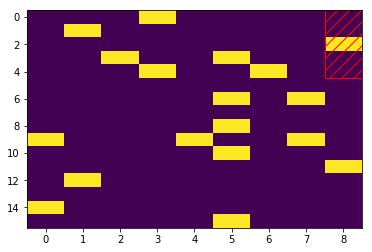

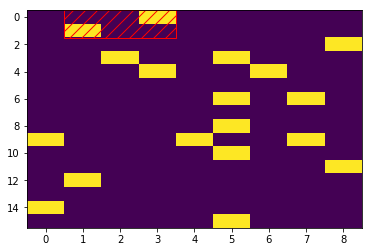

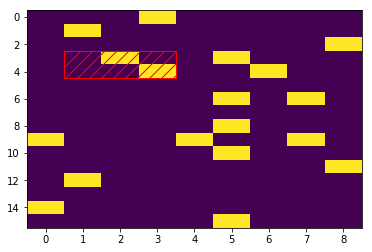

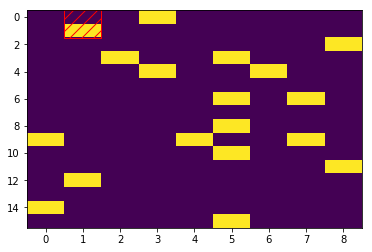

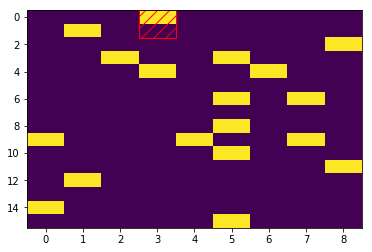

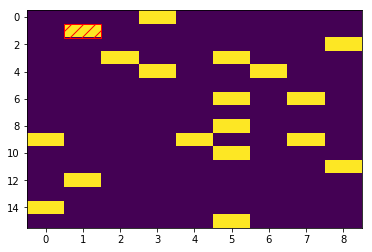

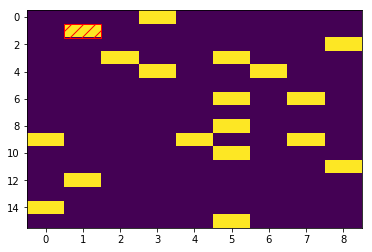

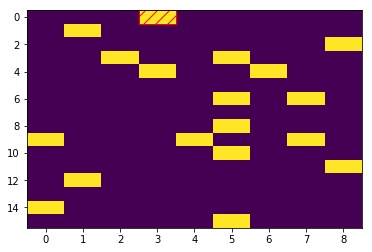

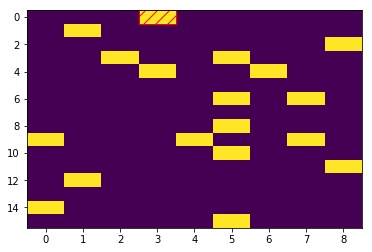

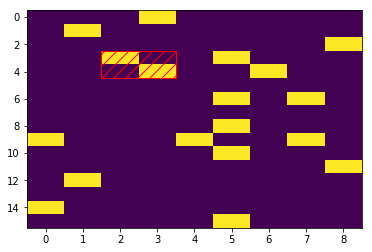

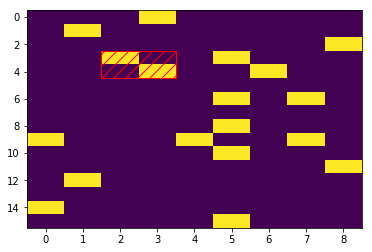

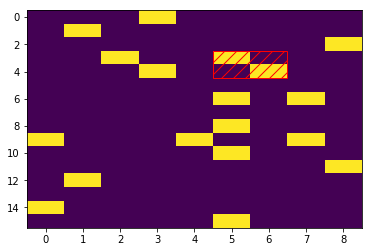

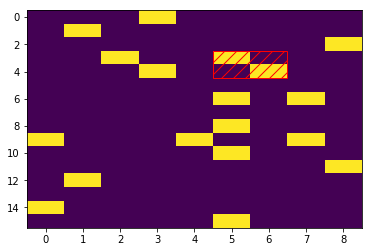

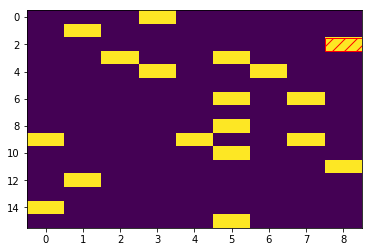

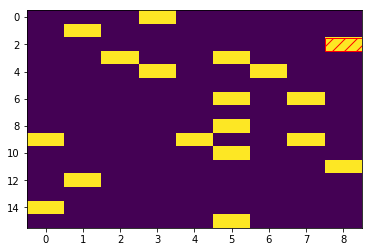

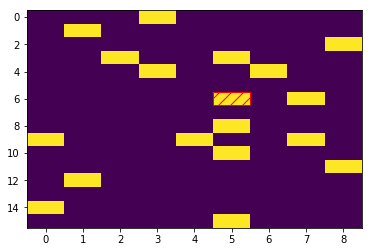

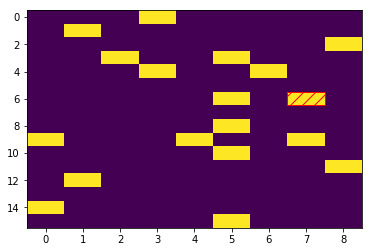

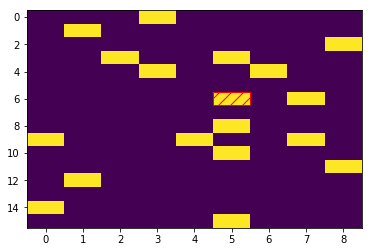

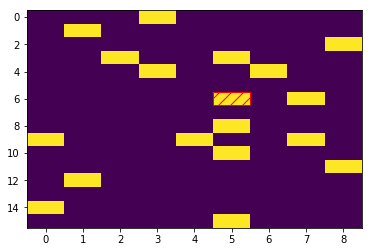

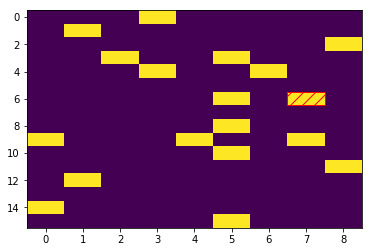

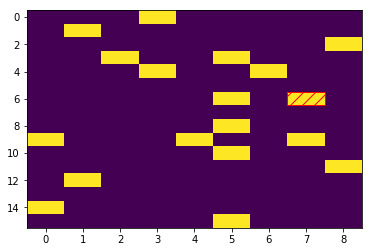

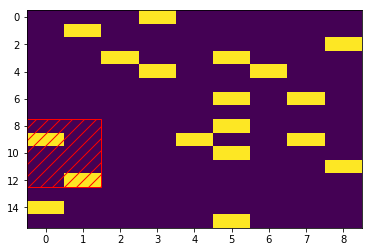

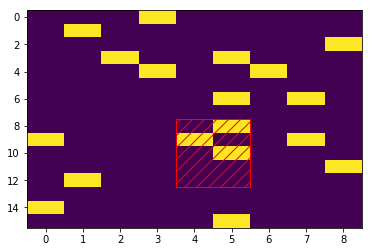

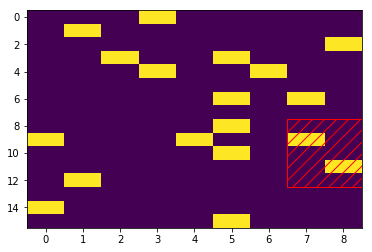

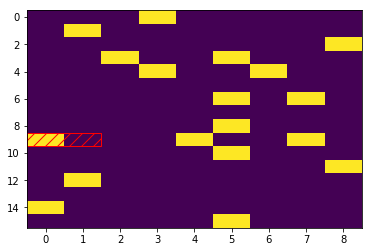

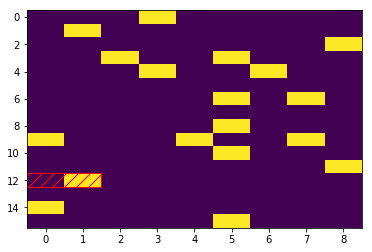

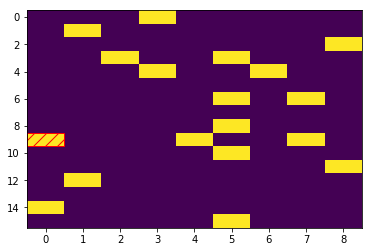

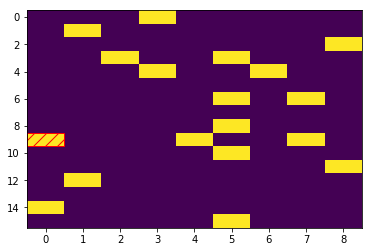

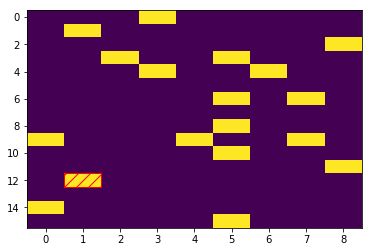

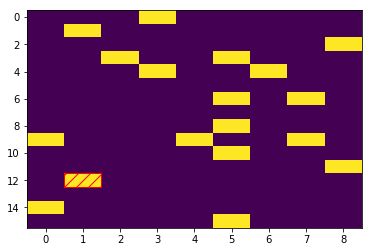

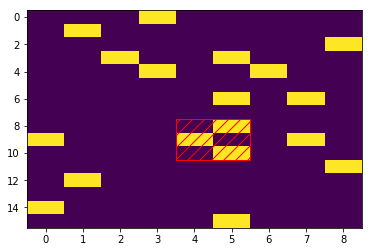

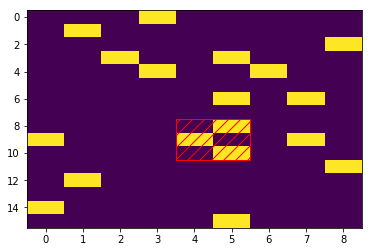

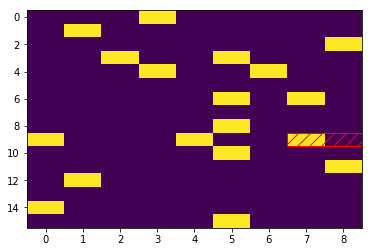

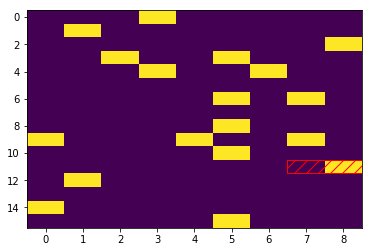

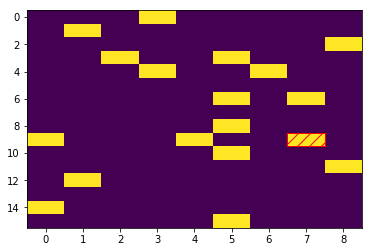

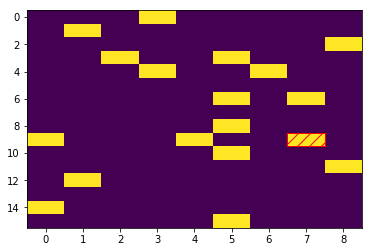

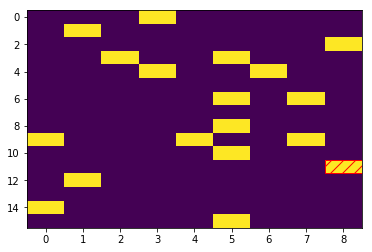

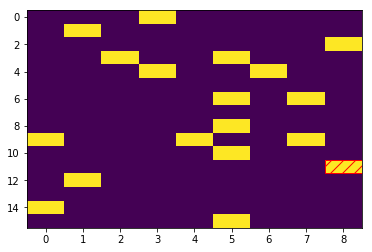

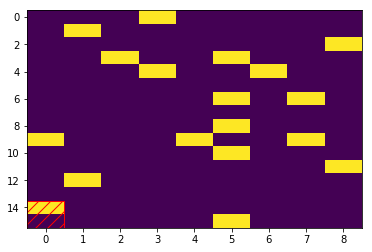

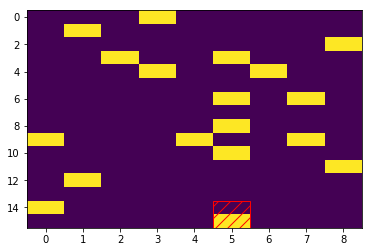

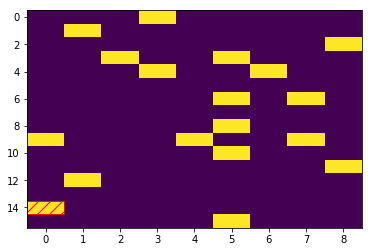

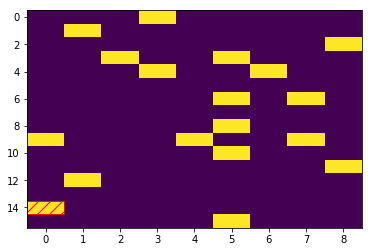

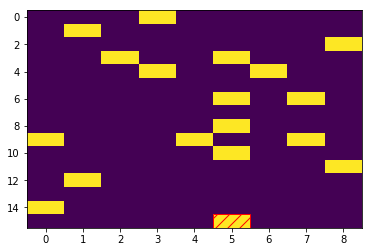

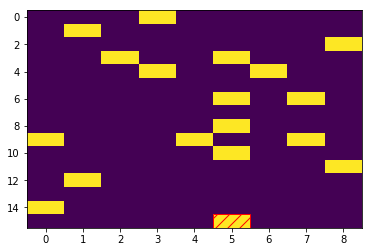

In [47]:
matches = re.findall("\[\d*, \d*, \d*, \d*\]", log_capture_string.getvalue())
for match in matches:
    array = ast.literal_eval(match)
    patch = patchfinder.patch.Patch(array[0], array[1], array[2], array[3])
    congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, [patch])

The function has returned the following _Patch objects_.

In [48]:
for patch in patches:
    print(patch)

xStart: 1 | xEnd: 1 | yStart: 1 | yEnd: 1
xStart: 0 | xEnd: 0 | yStart: 3 | yEnd: 3
xStart: 3 | xEnd: 4 | yStart: 2 | yEnd: 3
xStart: 3 | xEnd: 4 | yStart: 5 | yEnd: 6
xStart: 2 | xEnd: 2 | yStart: 8 | yEnd: 8
xStart: 6 | xEnd: 6 | yStart: 5 | yEnd: 5
xStart: 6 | xEnd: 6 | yStart: 7 | yEnd: 7
xStart: 9 | xEnd: 9 | yStart: 0 | yEnd: 0
xStart: 12 | xEnd: 12 | yStart: 1 | yEnd: 1
xStart: 8 | xEnd: 10 | yStart: 4 | yEnd: 5
xStart: 9 | xEnd: 9 | yStart: 7 | yEnd: 7
xStart: 11 | xEnd: 11 | yStart: 8 | yEnd: 8
xStart: 14 | xEnd: 14 | yStart: 0 | yEnd: 0
xStart: 15 | xEnd: 15 | yStart: 5 | yEnd: 5


To visualise the end result, the _Patch objects_ can be plotted together with the original array and its boolean representation.

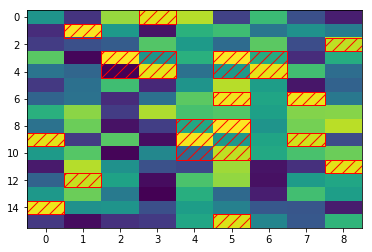

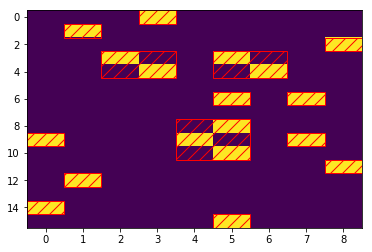

In [49]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patches)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patches)

Some _Patch objects_ may be deamed too small to be of interest. The _patch class_ contains a function which can filter these out based on a threshold value.

In [50]:
patchesFiltered = patchfinder.patch.filterLargePatches(patches, 1)

2018-01-03 14:49:21,078 - DEBUG - Starting filterLargePatches()
2018-01-03 14:49:21,078 - DEBUG - Starting filterLargePatches()
2018-01-03 14:49:21,078 - DEBUG - Ending filterLargePatches()
2018-01-03 14:49:21,078 - DEBUG - Ending filterLargePatches()


The result is a shorter list of _Patch objects_.

In [52]:
for patch in patchesFiltered:
    print(patch)

xStart: 3 | xEnd: 4 | yStart: 2 | yEnd: 3
xStart: 3 | xEnd: 4 | yStart: 5 | yEnd: 6
xStart: 8 | xEnd: 10 | yStart: 4 | yEnd: 5


These can also be visualised.

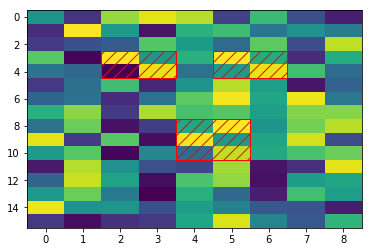

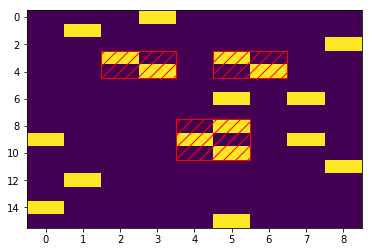

In [53]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patchesFiltered)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patchesFiltered)

### Speed and Flows (part 2)

The _speedflow class_ has additional functions to deal with _Patch objects_. In particular, it can use the _masks_ from the missing detectors and the low-flow times to reconstruct the patches as they would have been before the filtering.

In [34]:
patches = []
patches.append(patchfinder.patch.Patch(2, 3, 4, 5))
patches.append(patchfinder.patch.Patch(0, 2, 1, 3))
patches.append(patchfinder.patch.Patch(3, 3, 0, 1))
maskSpace = [True, True, False, True, True]
maskTime = [True, True, True, True, False, True, True]
speedFlowPatches = congestionfinder.speedflow.unmaskPatches(patches, maskSpace, maskTime)

2018-01-03 13:40:07,538 - DEBUG - Starting unmaskPatches()
2018-01-03 13:40:07,538 - DEBUG - Ending unmaskPatches()


As can be seen in the list below, the starts and ends shift depending on whether an additional space or time index was added.

In [35]:
for patch in speedFlowPatches:
    print(patch)

xStart: 3 | xEnd: 4 | yStart: 5 | yEnd: 6
xStart: 0 | xEnd: 3 | yStart: 1 | yEnd: 3
xStart: 4 | xEnd: 4 | yStart: 0 | yEnd: 1


The _speedflow class_ can also add margins to the _Patch objects_. This is important to undo some of the effect of the coarse-graining which occured when the _congestion_ array was smoothed. To ensure that the function does not create unrealistic margins, the original boundaries of the _speed_ and _flow_ arrays need to be used.

In [36]:
patches = []
patches.append(patchfinder.patch.Patch(2, 3, 4, 5))
patches.append(patchfinder.patch.Patch(0, 2, 1, 3))
patches.append(patchfinder.patch.Patch(3, 3, 0, 1))
marginSpace = 2
marginTime = 1
minSpaceIndex = 0
maxSpaceIndex = 15
minTimeIndex = 0
maxTimeIndex = 8
patchesWithMargins = congestionfinder.speedflow.addMargins(patches, marginSpace, marginTime, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex)

2018-01-03 13:40:39,915 - DEBUG - Starting addMargins()
2018-01-03 13:40:39,930 - DEBUG - Ending addMargins()


As can be seen in the list below, the starts shift downward and the ends shift upward, unless the boundary of the array is hit.

In [37]:
for patch in patchesWithMargins:
    print(patch)

xStart: 0 | xEnd: 5 | yStart: 3 | yEnd: 6
xStart: 0 | xEnd: 4 | yStart: 0 | yEnd: 4
xStart: 1 | xEnd: 5 | yStart: 0 | yEnd: 2


End of Notebook